In [123]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import urllib
import matplotlib.pyplot as plt

def qstring(stationID,parameter,sdate,td):
    data = {
        'stationID':stationID,
        'param':parameter,
        'type':'hr',
        'sdate':sdate,
        'edate':td,
        'stime':'00',
        'etime':'23'
    }
    return urllib.parse.urlencode(data)

td = datetime.datetime.now().strftime('%Y-%m-%d')

params = lambda stationID,parameter: qstring(stationID = stationID,parameter=parameter,sdate='2019-07-01',td=td)
uri = lambda stationID,parameter: f'http://air4thai.pcd.go.th/webV2/history/api/data.php?{params(stationID,parameter)}'

stajson = (pd.io.json.json_normalize(requests.get('http://air4thai.pcd.go.th/services/getNewAQI_JSON.php')
                                     .json()['stations']))
columns = ['nameTH', 'stationID','lat', 'long']
sta = stajson[columns]

df = None
for station in tqdm(sta['stationID'],ncols=75):
    try:
        temp = (pd.DataFrame(requests.get(uri(station,'PM2.5')).json()['stations'][0]['data'])
                .replace({'-':None})
                .set_index('DATETIMEDATA')
                .assign(stationID = station))
        df = pd.concat([df,temp])
    except:
        pass



100%|████████████████████████████████████| 117/117 [00:04<00:00, 16.50it/s]


In [32]:
pol = (sta.merge(
    df.reset_index().pivot_table(index='stationID',columns='DATETIMEDATA',values='PM25').reset_index(),
    how='right'))
lat = pol['lat'].astype('float')
long = pol['long'].astype('float')

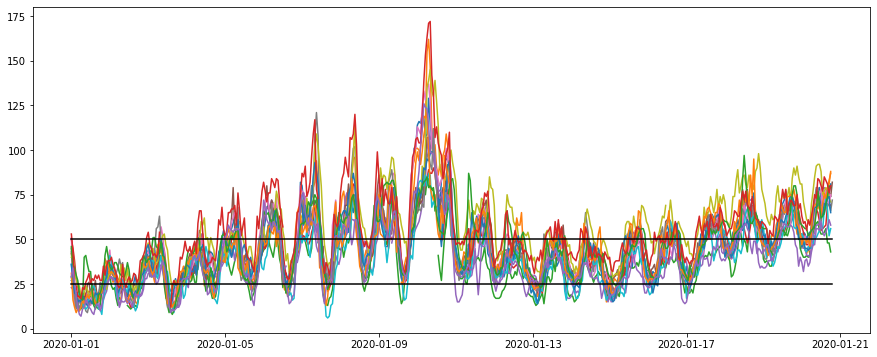

In [127]:

area = (lat >= 13.651747) & (lat <= 13.964071) & (long >= 100.319413) & (long <= 100.727313)
#area = (lat >= 18.654674)
#area_pattaya = (lat >= 12.775890) & (lat <= 13.234109) & (long >= 100.832553) & (long <= 101.046830)

pm25 = pol[area].T.iloc[4:].astype('float')

pm25.index = pd.to_datetime(pm25.index)
pm25 = pm25['2020']
ma = pm25.rolling(24,center=False).mean()

plt.figure(figsize = (15,6))
plt.plot(pm25)
plt.plot(pd.Series(50,index=pm25.index),color='black')
plt.plot(pd.Series(25,index=pm25.index),color='black')

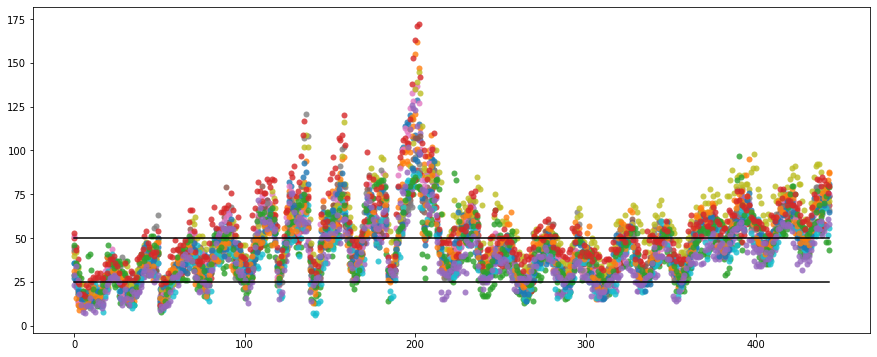

In [128]:
x = pm25.dropna().reset_index().index.values
y = pm25.dropna().values

plt.figure(figsize = (15,6))
for Y in y.T:
    plt.scatter(x=x,y=Y,alpha=0.8,lw=0.01)

plt.plot(pd.Series(50,index=x),color='black')
plt.plot(pd.Series(25,index=x),color='black')

Last timestamp : 2020-01-20 19:00:00


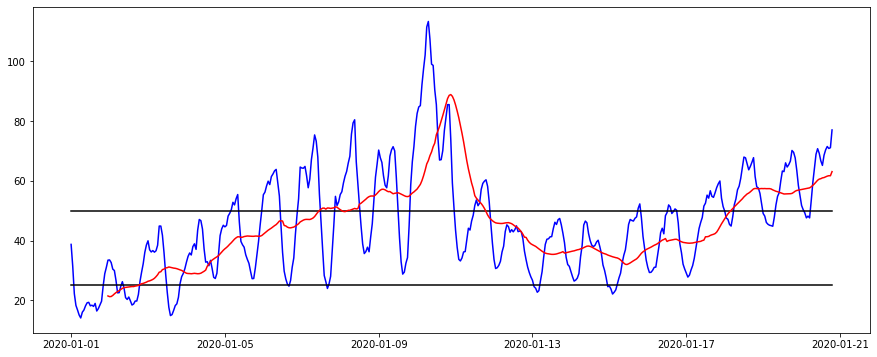

In [130]:
print(f'Last timestamp : {pm25.index[-1]}')
x = pm25.dropna().reset_index().index.values
y = pm25.dropna().values
plt.figure(figsize = (15,6))
plt.plot(pm25.mean(axis=1),color='blue')
plt.plot(pd.Series(50,index=pm25.index),color='black')
plt.plot(pd.Series(25,index=pm25.index),color='black')
plt.plot(ma.mean(axis=1),color='red')
plt.show()

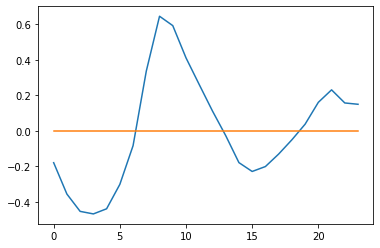

In [141]:
import numpy as np

pm25['mean'] = pm25.mean(axis=1) 
pm25['hour'] = pm25.reset_index()['index'].dt.hour.values
pm25['day'] = pm25.reset_index()['index'].dt.date.values

#meanday = ma.groupby('day')['mean'].mean()
byhour = pm25.groupby(['day','hour'])['mean'].mean().unstack()
meanday = byhour.mean(axis=1)
sdday = byhour.std(axis=1)
z_score = (byhour.values - meanday.values.reshape(20,1))/sdday.values.reshape(20,1)

# Z score of PM 2.5 at different time of the day

plt.plot(z_score[:-1].mean(axis=0))
plt.plot(np.repeat(0,24))